# matmul Behavior

Sick of matrix multiplicaton yet? Let's do some more.

The goal of this notebook is to convince ourselves that a `matmul` can only run on device if the inputs are:

1. At least two-dimensional
2. In `TILE_LAYOUT`
3. In `bfloat16` data format.

We'll explore several methods in tilizing the inputs.

First, we'll see how `matmul` won't work when attempting to multiply tensors in `ROW_MAJOR_LAYOUT`. 

Then, we will fix the problem by using `ttnn.to_layout`, then see how we can just create the tensors in `TILE_LAYOUT` in the first place.

There is also the the `tilize` function which we will explore and understand why it doesn't work for all tensors in converting to a tile layout for operation

It will be good to set the environment variables to disable the fast runtime mode before importing the `ttnn` library.

In [1]:
import os

os.environ["TTNN_CONFIG_OVERRIDES"] = "{\"enable_fast_runtime_mode\": false}"

## Dependencies

Import the required dependencies, especially `trace` and `visualize` since we would like to see how things behave.

In [2]:
import torch
import ttnn
from ttnn.tracer import visualize, trace

2025-04-20 08:14:43.715 | DEBUG    | ttnn:<module>:80 - Loading ttnn configuration overrides from environment variable TTNN_CONFIG_OVERRIDES
2025-04-20 08:14:43.717 | DEBUG    | ttnn:<module>:83 - Initial ttnn.CONFIG:
Config{cache_path=/home/avgdev/.cache/ttnn,model_cache_path=/home/avgdev/.cache/ttnn/models,tmp_dir=/tmp/ttnn,enable_model_cache=false,enable_fast_runtime_mode=false,throw_exception_on_fallback=false,enable_logging=false,enable_graph_report=false,enable_detailed_buffer_report=false,enable_detailed_tensor_report=false,enable_comparison_mode=false,comparison_mode_should_raise_exception=false,comparison_mode_pcc=0.9999,root_report_path=generated/ttnn/reports,report_name=std::nullopt,std::nullopt}


Since a lot of operations almost always requires a handle to the device, we'll open it and use it as a reference.

In [3]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

                 Device | INFO     | Opening user mode device driver
2025-04-20 08:14:45.335 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled

2025-04-20 08:14:45.347 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-04-20 08:14:45.349 | INFO     | SiliconDriver   - Harvesting mask for chip 0 is 0x200 (physical layout: 0x1, logical: 0x200, simulated harvesting mask: 0x0).
2025-04-20 08:14:45.350 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-04-20 08:14:45.350 | INFO     | SiliconDriver   - Detected PCI devices: [0]
2025-04-20 08:14:45.350 | INFO     | SiliconDriver   - Using local chip ids: {0} and remote chip ids {}
2025-04-20 08:14:45.376 | INFO     | SiliconDriver   - Software version 6.0.0, Ethernet FW version 6.14.0 (Device 0)
                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | 

New chip! We now have 1 chips
Chip initialization complete (found )
Chip initializing complete...
 ARC

 [4/4] DRAM

 [16/16] ETH

 CPU

Chip detection complete (found )


## Create Input Tensors

We'll start by seeing why we won't be able to multiply 2 tensors straight away. Let's create 2 random (5, 5) tensors in `bfloat16` data format. They will just be filled with random values.

The visualization should indicate that the tensors are in `ROW_MAJOR_LAYOUT`.

2025-04-20 08:14:48.742 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-04-20 08:14:48.744 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
            

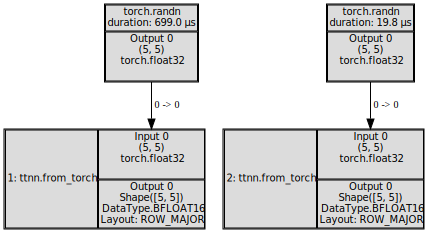

In [4]:
with trace():
  a = ttnn.from_torch(
    torch.randn(5, 5),
    dtype=ttnn.bfloat16
  );

  b = ttnn.from_torch(
    torch.randn(5, 5),
    dtype=ttnn.bfloat16
  );

visualize(a)
visualize(b)

Now, let's send these tensors to the device. Everything should still be OK at this point.

2025-04-20 08:14:50.666 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-04-20 08:14:50.670 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                 Always | INFO     | Begin op: Tensor::to_device
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::BorrowedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | End op: Tensor::to_device
                 Always | INFO     | Begin op: Tensor::to_device
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::BorrowedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | End op: Tensor::to_device


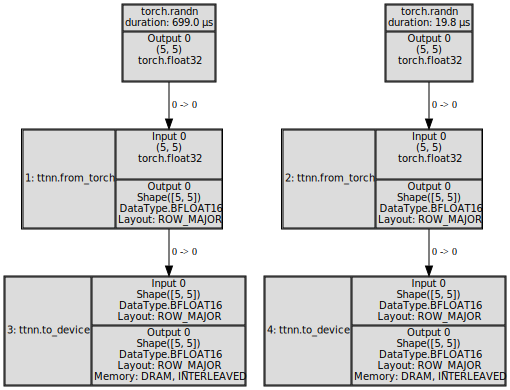

In [5]:
with trace():
  a = ttnn.to_device(a, device)
  b = ttnn.to_device(b, device)

visualize(a)
visualize(b)

At this point the tensors `a` and `b` are in device storage (DRAM), in `bfloat16`, and most importantly, still in `ROW_MAJOR_LAYOUT`. 

We'll multiply but its expected that the multiplication will not work. the matrices need to be in `TILE_LAYOUT`. A sample exception is thrown indicating that we have to work in tiled format:

```
RuntimeError: TT_FATAL @ /work/ttnn/cpp/ttnn/operations/matmul/device/matmul_op.cpp:1417: (input_tensor_a.get_layout() == Layout::TILE && input_tensor_b.get_layout() == Layout::TILE)
info:
Inputs to matmul must be tilized
backtrace:
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0xf2f318) [0x7e28f5d2f318]
 --- ttnn::operations::matmul::Matmul::validate(std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>> const&)
```

Note that we need to add exception handling here to close the device properly.

In [6]:
try:
  with trace():
    c = ttnn.matmul(a, b)
except Exception as e:
  ttnn.close_device(device)
  ttnn.tracer.disable_tracing()
  raise e


                 Always | INFO     | Begin op: ttnn::matmul
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::MemoryConfig const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<std::__1::variant<ttnn::operations::matmul::MatmulMultiCoreProgramConfig, ttnn::operations::matmul::MatmulMultiCoreNonOptimizedReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseMultiCastProgramConfig, ttnn::operations::matmul::MatmulM

RuntimeError: TT_FATAL @ /work/ttnn/cpp/ttnn/operations/matmul/device/matmul_op.cpp:1417: (input_tensor_a.get_layout() == Layout::TILE && input_tensor_b.get_layout() == Layout::TILE)
info:
Inputs to matmul must be tilized
backtrace:
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0xf2f318) [0x74ab50b2f318]
 --- ttnn::operations::matmul::Matmul::validate(std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>> const&) const
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x20b843f) [0x74ab51cb843f]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x20b83b7) [0x74ab51cb83b7]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(_ZN4ttnn16device_operation6detail23launch_on_worker_threadIN2tt8tt_metal9operation23OldInfraDeviceOperationINSt3__16vectorINS4_6TensorENS7_9allocatorIS9_EEEEEENS3_3stl10StrongTypeIhNS_10QueueIdTagEEElNS5_15DeviceOperationISC_EENSD_13tensor_args_tESC_PNS4_7IDeviceEEEvT0_T1_RKT2_RKT3_RT4_RT5_+0x23e) [0x74ab52c07cde]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(_ZN4ttnn16device_operation6detail23launch_on_single_deviceIN2tt8tt_metal9operation23OldInfraDeviceOperationINSt3__16vectorINS4_6TensorENS7_9allocatorIS9_EEEEEEEENT_21tensor_return_value_tENS3_3stl10StrongTypeIhNS_10QueueIdTagEEERKNSE_22operation_attributes_tERKNSE_13tensor_args_tE+0x83) [0x74ab52c079f3]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x30078ea) [0x74ab52c078ea]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(_ZN4ttnn16device_operation6detail6invokeIN2tt8tt_metal9operation23OldInfraDeviceOperationINSt3__16vectorINS4_6TensorENS7_9allocatorIS9_EEEEEEEENT_21tensor_return_value_tENS3_3stl10StrongTypeIhNS_10QueueIdTagEEERKNSE_22operation_attributes_tERKNSE_13tensor_args_tE+0x197) [0x74ab52c072a7]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x3006c5b) [0x74ab52c06c5b]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x300693b) [0x74ab52c0693b]
 --- std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> tt::tt_metal::operation::run<std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>>(tt::tt_metal::operation::DeviceOperation<std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>>&&, std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>> const&, tt::stl::StrongType<unsigned char, ttnn::QueueIdTag>)
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x20b7e68) [0x74ab51cb7e68]
 --- void tt::tt_metal::operation::launch_op_func<std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>>(std::__1::function<std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> (std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>> const&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>> const&)> const&, std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>, std::__1::vector<tt::tt_metal::Tensor, std::__1::allocator<tt::tt_metal::Tensor>>&, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor const>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor const>>>, std::__1::vector<std::__1::optional<tt::tt_metal::Tensor>, std::__1::allocator<std::__1::optional<tt::tt_metal::Tensor>>>)
 --- ttnn::operations::matmul::matmul(tt::tt_metal::Tensor const&, tt::tt_metal::Tensor const&, std::__1::optional<tt::tt_metal::Tensor const> const&, ttnn::operations::matmul::Matmul const&, tt::stl::StrongType<unsigned char, ttnn::QueueIdTag>, std::__1::optional<tt::tt_metal::Tensor> const&)
 --- ttnn::operations::matmul::bound_matmul(tt::tt_metal::Tensor const&, tt::tt_metal::Tensor const&, std::__1::optional<tt::tt_metal::Tensor const> const&, ttnn::operations::matmul::Matmul const&, unsigned char const&, std::__1::optional<tt::tt_metal::Tensor>&)
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(_ZN4ttnn10operations6matmul15MatmulOperation6invokeERKN2tt8tt_metal6TensorES7_bbRKNSt3__18optionalIKNS4_12MemoryConfigEEENS9_IKNS4_8DataTypeEEERKNS9_IKNS8_7variantIJNS1_28MatmulMultiCoreProgramConfigENS1_45MatmulMultiCoreNonOptimizedReuseProgramConfigENS1_33MatmulMultiCoreReuseProgramConfigENS1_42MatmulMultiCoreReuseMultiCastProgramConfigENS1_44MatmulMultiCoreReuseMultiCast1DProgramConfigENS1_53MatmulMultiCoreReuseMultiCastDRAMShardedProgramConfigEEEEEERKNS9_IKNS8_12basic_stringIcNS8_11char_traitsIcEENS8_9allocatorIcEEEEEENS9_IKNSI_IJNS_28GrayskullComputeKernelConfigENS_27WormholeComputeKernelConfigEEEEEENS9_IKNS_5types8CoreGridEEERKNS9_IKNS4_4TileEEENS9_IS5_EERKNS9_IKNSI_IJNS8_9monostateENS4_12experimental20GlobalCircularBufferENS_22global_circular_buffer31MultiDeviceGlobalCircularBufferEEEEEERKNS9_INS3_3stl10StrongTypeIhNS4_14SubDeviceIdTagEEEEE+0x367) [0x74ab51c9ffa7]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x16e03d3) [0x74ab512e03d3]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x16bc47b) [0x74ab512bc47b]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0x16bc2ab) [0x74ab512bc2ab]
 --- /home/avgdev/code/tt-sandbox/.venv/lib/python3.10/site-packages/ttnn/_ttnn.cpython-310-x86_64-linux-gnu.so(+0xecbfa9) [0x74ab50acbfa9]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x114903) [0x74ac04d14903]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyObject_MakeTpCall+0x92) [0x74ac04cc9de2]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xcca6a) [0x74ac04ccca6a]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x136fba) [0x74ac04d36fba]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyObject_Call+0x5d) [0x74ac04cc9b7d]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x49c8) [0x74ac04c6f728]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x49c8) [0x74ac04c6f728]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x49c8) [0x74ac04c6f728]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyObject_FastCallDictTstate+0x6b) [0x74ac04cc9f3b]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyObject_Call_Prepend+0x110) [0x74ac04cca280]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x136fe8) [0x74ac04d36fe8]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyObject_MakeTpCall+0x92) [0x74ac04cc9de2]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x7f13) [0x74ac04c72c73]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(PyEval_EvalCode+0xd2) [0x74ac04dc33d2]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1bc321) [0x74ac04dbc321]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1150f1) [0x74ac04d150f1]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6191) [0x74ac04c70ef1]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xdff3e) [0x74ac04cdff3e]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x8f20) [0x74ac04c73c80]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xdff3e) [0x74ac04cdff3e]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x8f20) [0x74ac04c73c80]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xe0c5e) [0x74ac04ce0c5e]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xd42dd) [0x74ac04cd42dd]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6ee9) [0x74ac04c71c49]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6191) [0x74ac04c70ef1]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6ee9) [0x74ac04c71c49]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xcca10) [0x74ac04ccca10]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(PyVectorcall_Call+0xcc) [0x74ac04cc9a3c]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x49c8) [0x74ac04c6f728]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xcca10) [0x74ac04ccca10]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6119) [0x74ac04c70e79]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xdff3e) [0x74ac04cdff3e]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x8f20) [0x74ac04c73c80]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xdff3e) [0x74ac04cdff3e]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x8f20) [0x74ac04c73c80]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xdff3e) [0x74ac04cdff3e]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x8f20) [0x74ac04c73c80]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xdff3e) [0x74ac04cdff3e]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x8f20) [0x74ac04c73c80]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xdff3e) [0x74ac04cdff3e]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x8f20) [0x74ac04c73c80]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xdff3e) [0x74ac04cdff3e]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/python3.10/lib-dynload/_asyncio.cpython-310-x86_64-linux-gnu.so(+0x9c41) [0x74ac047b9c41]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/python3.10/lib-dynload/_asyncio.cpython-310-x86_64-linux-gnu.so(+0xa7df) [0x74ac047ba7df]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x114cde) [0x74ac04d14cde]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1da26b) [0x74ac04dda26b]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x114f69) [0x74ac04d14f69]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x49c8) [0x74ac04c6f728]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6ee9) [0x74ac04c71c49]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6ee9) [0x74ac04c71c49]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6ee9) [0x74ac04c71c49]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6ee9) [0x74ac04c71c49]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6ee9) [0x74ac04c71c49]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0xcca10) [0x74ac04ccca10]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x7eda) [0x74ac04c72c3a]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(PyEval_EvalCode+0xd2) [0x74ac04dc33d2]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1bc321) [0x74ac04dbc321]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1150f1) [0x74ac04d150f1]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6191) [0x74ac04c70ef1]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(_PyEval_EvalFrameDefault+0x6191) [0x74ac04c70ef1]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x1c35a4) [0x74ac04dc35a4]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(+0x22afea) [0x74ac04e2afea]
 --- /home/avgdev/.pyenv/versions/3.10.12/lib/libpython3.10.so.1.0(Py_RunMain+0x362) [0x74ac04e2b5a2]



## Operating in TILE_LAYOUT

We'll now explore why the input tensors need to be in `TILE_LAYOUT`.

Since we're going to be initializing the input tensors quite often, let's create a helper called `initialize_tensors` to give us back the tensors in either layout. By default, it will be `ROW_MAJOR_LAYOUT` so that we have some control on _when_ we want to convert the tensors to `TILE_LAYOUT`.

In [7]:
def initialize_tensors(layout=ttnn.ROW_MAJOR_LAYOUT):
  with trace():
    a = ttnn.from_torch(
      torch.randn(5, 5),
      dtype=ttnn.bfloat16,
      layout=layout
    );

    b = ttnn.from_torch(
      torch.randn(5, 5),
      dtype=ttnn.bfloat16,
      layout=layout
    );

    a = ttnn.to_device(a, device)
    b = ttnn.to_device(b, device)

  return a, b

### Using to_layout() to Convert to TILE_LAYOUT

Our first demo shows that we can convert the tensors to `TILE_LAYOUT` using the `to_layout` function just before we execute `matmul`. 

We'll see that in the visualization that the 2 tensors are in `TILE_LAYOUT` within the device just before the `ttnn.matmul` operation occurs (last node).

                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1:

2025-04-20 08:14:58.929 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


 type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name i

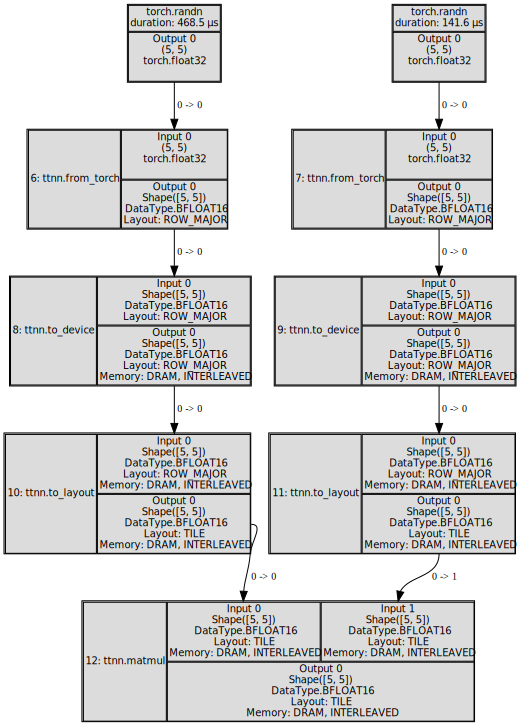

In [8]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

a, b = initialize_tensors()

try:
  with trace():
    a = ttnn.to_layout(a, ttnn.TILE_LAYOUT)
    b = ttnn.to_layout(b, ttnn.TILE_LAYOUT)

    c = ttnn.matmul(a, b)
except Exception as e:
  ttnn.close_device(device)
  ttnn.tracer.disable_tracing()
  raise e

visualize(c)


Close the device as we'll open it again in the next example.

In [9]:

ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


### Using tilize_with_val_padding

Next, let's see what happens when we use `tilize_with_val_padding` to tilize the tensors before the matrix multiplication.

https://docs.tenstorrent.com/tt-metal/latest/ttnn/ttnn/api/ttnn.tilize_with_val_padding.html#ttnn.tilize_with_val_padding

We'll hardcode the `output_tensor_shape` to be (32, 32) since we know that's the next size up in which the device can operate on.

2025-04-20 08:15:02.837 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1:

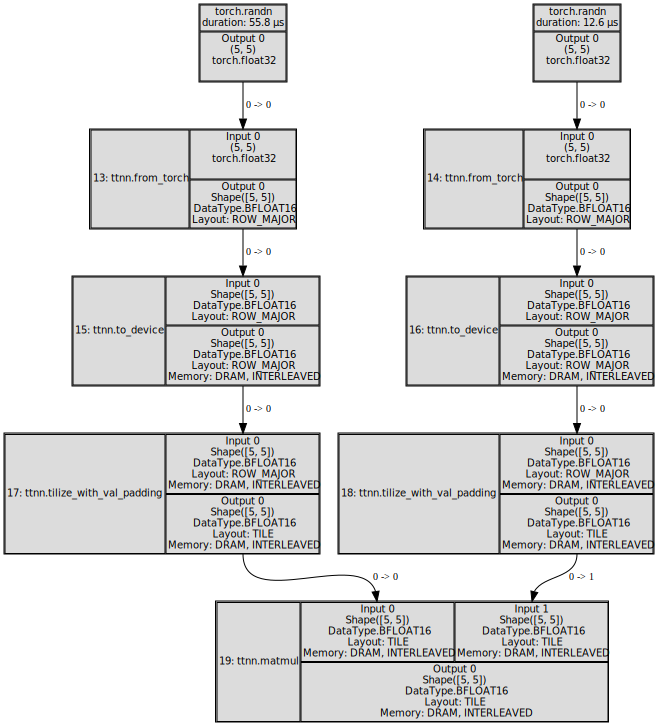

In [10]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

a, b = initialize_tensors()

try:
  with trace():
    a = ttnn.tilize_with_val_padding(a, output_tensor_shape=(32, 32), pad_value=0)
    b = ttnn.tilize_with_val_padding(b, output_tensor_shape=(32, 32), pad_value=0)

    c = ttnn.matmul(
      a,
      b
    )
except Exception as e:
  ttnn.close_device(device)
  ttnn.tracer.disable_tracing()
  raise e

visualize(c)

As with the previous example, let's close the device.

In [11]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


### Creating Input Tensors as TILE_LAYOUT Directly

The last working example I want to show is if we just create the input tensors as `TILE_LAYOUT` directly.

This is the easiest way to setup the input tensors for multiplication. Since our `initialize_tensors` already creates the tensors in `TILE_LAYOUT` based on argument, we just pass in the `TILE_LAYOUT` argument, overriding the default `ROW_MAJOR_LAYOUT` argument.

2025-04-20 08:15:07.581 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz
                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1:

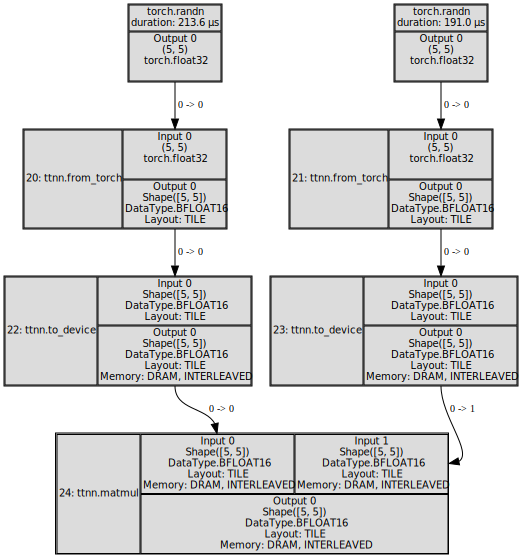

In [12]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

a, b = initialize_tensors(ttnn.TILE_LAYOUT)

try:
  with trace():
    c = ttnn.matmul(a, b)
except Exception as e:
  ttnn.close_device(device)
  ttnn.tracer.disable_tracing()
  raise e

visualize(c)

Close the device again.

In [13]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


## Why not use tilize?

`tilize` also changes the layout of a tensor from `ROW_MAJOR_LAYOUT` to `TILE_LAYOUT`. However, it does not do padding by default. You'll need to do that yourself. `matmul` will not work with `tilize`'d tensors passed in directly and will throw an error. 

Instead using `tilize_with_val_padding` as we did earlier, if you want to not use `to_layout`. 